# Air Quality Analysis - Paris - Ozone (O3) - 2022

**Objective:** Analyze ozone pollution trends in Paris using EEA air quality data.

**Summary:**
- Data acquisition from public APIs
- Data cleaning and validation
- Time series analysis
- Statistical analysis
- Data visualization

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
from pathlib import Path

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Download Data from EEA API

In [2]:
# EEA API endpoint
api_url = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/ParquetFile"

# Request parameters
params = {
    "countries": ["FR"],
    "cities": ["Paris (greater city)"],
    "pollutants": ["O3"],
    "dataset": 2,  # Verified data
    "dateTimeStart": "2022-01-01T00:00:00.000Z",
    "dateTimeEnd": "2022-12-31T23:59:59.000Z"
}

# Download data
print("Downloading data...")
response = requests.post(api_url, json=params, timeout=300)

# Save and extract
Path('data').mkdir(exist_ok=True)
with open('data/paris_o3.zip', 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile('data/paris_o3.zip', 'r') as zip_ref:
    zip_ref.extractall('data/paris_o3')

print(f"Downloaded {len(response.content)/1024:.1f} KB")

Downloaded 516.2 KB


## 3. Load and Clean Data

In [55]:
# Load all parquet files
files = list(Path('data/paris_o3').glob('**/*.parquet'))
df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

print(f"Loaded {len(df):,} measurements")
print(f"Date range: {df['Start'].min()} to {df['Start'].max()}")
print(f"Monitoring Stations: {df['Samplingpoint'].nunique()}")

Loaded 113,843 measurements
Date range: 2022-01-01 00:00:00 to 2022-12-31 22:00:00
Monitoring Stations: 13


In [56]:
# Clean data
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df = df.dropna(subset=['Value'])
df = df[df['Value'] > 0]  # Remove invalid values

# Add time features
df['DateTime'] = pd.to_datetime(df['Start'])
df['Date'] = df['DateTime'].dt.date
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

print(f"Clean dataset: {len(df):,} measurements")

Clean dataset: 108,749 measurements


## 4. Statistical Analysis

In [57]:
# Calculate statistics
print("\n=== O3 STATISTICS (µg/m³) ===")
print(f"Mean:              {df['Value'].mean():.1f}")
print(f"Median:            {df['Value'].median():.1f}")
print(f"Std Dev:           {df['Value'].std():.1f}")
print(f"Min:               {df['Value'].min():.1f}")
print(f"Max:               {df['Value'].max():.1f}")
print(f"25th Percentile:   {df['Value'].quantile(0.25):.1f}")
print(f"75th Percentile:   {df['Value'].quantile(0.75):.1f}")
print(f"95th Percentile:   {df['Value'].quantile(0.95):.1f}")

# WHO guideline exceedances
who_limit = 100
exceedances = (df['Value'] > who_limit).sum()
exceedance_pct = (exceedances / len(df)) * 100
print(f"\nWHO Exceedances (>{who_limit}): {exceedances:,} ({exceedance_pct:.1f}%)")


=== O3 STATISTICS (µg/m³) ===
Mean:              50.2
Median:            49.9
Std Dev:           29.0
Min:               0.1
Max:               212.2
25th Percentile:   29.7
75th Percentile:   68.0
95th Percentile:   100.6

WHO Exceedances (>100): 5,590 (5.1%)


## 5. Visualizations

Air Quality Analysis in Paris - O3 (Ozone)
---
Location: Paris region, France
Period: January - December 2022
Monitoring Stations: 13
Total Measurements: 108,749


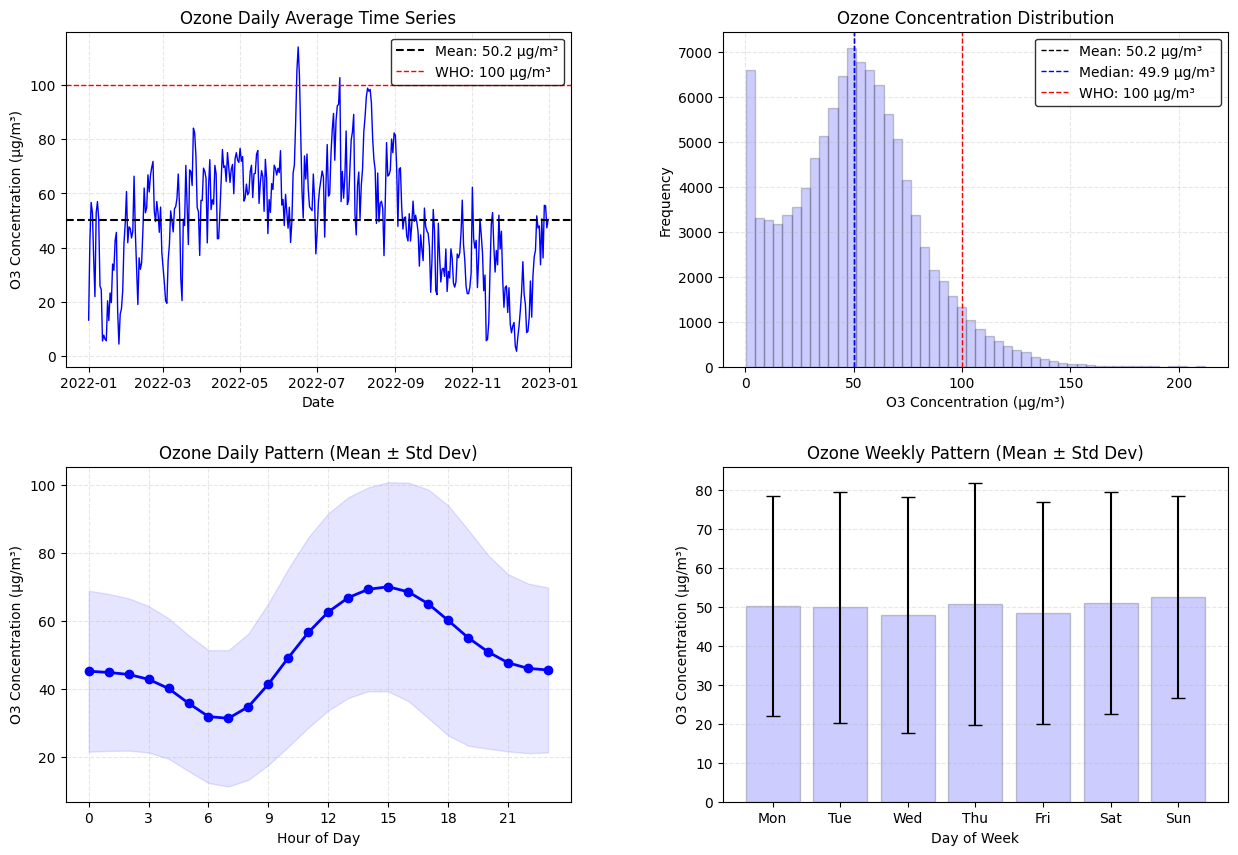

In [77]:
# Create 4 visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#fig.suptitle('Air Quality Analysis in Paris: Ozone trend study (Jan-Dec 2022)', fontsize=14, fontweight='normal')
print("Air Quality Analysis in Paris - O3 (Ozone)")
print("---")
print("Location: Paris region, France")
print("Period: January - December 2022")
print(f"Monitoring Stations: {df['Samplingpoint'].nunique()}")
print(f"Total Measurements: {len(df):,}")



# 1. Time series - daily average
daily_avg = df.groupby('Date')['Value'].mean()
axes[0, 0].plot(daily_avg.index, daily_avg.values, linewidth=1, color='blue')
axes[0, 0].axhline(df['Value'].mean(), color='black', linestyle='--', 
                   label=f"Mean: {df['Value'].mean():.1f} µg/m³")
axes[0, 0].axhline(who_limit, color='red', linestyle='--', linewidth=1, label=f'WHO: {who_limit} µg/m³')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('O3 Concentration (µg/m³)')
axes[0, 0].set_title('Ozone Daily Average Time Series')
axes[0, 0].legend(edgecolor="black")
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# 2. Distribution
axes[0, 1].hist(df['Value'], bins=50, color='blue', alpha=0.20, edgecolor='black')
axes[0, 1].axvline(df['Value'].mean(), color='black', linestyle='--', linewidth=1, label=f'Mean: {df["Value"].mean():.1f} µg/m³')
axes[0, 1].axvline(df['Value'].median(), color='blue', linestyle='--', linewidth=1, label=f'Median: {df["Value"].median():.1f} µg/m³')
axes[0, 1].axvline(who_limit, color='red', linestyle='--', linewidth=1, label=f'WHO: {who_limit} µg/m³')
axes[0, 1].set_xlabel('O3 Concentration (µg/m³)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Ozone Concentration Distribution')
axes[0, 1].legend(edgecolor="black")
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# 3. Hourly patterns
hourly_avg = df.groupby('Hour')['Value'].agg(['mean', 'std']).reset_index()
axes[1, 0].plot(hourly_avg['Hour'], hourly_avg['mean'], marker='o', linewidth=2, color='blue')
axes[1, 0].fill_between(hourly_avg['Hour'], 
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.10, color='blue')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('O3 Concentration (µg/m³)')
axes[1, 0].set_title('Ozone Daily Pattern (Mean ± Std Dev)')
axes[1, 0].set_xticks(range(0, 24, 3))
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# 4. Weekly patterns
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_avg = df.groupby('DayOfWeek')['Value'].agg(['mean', 'std']).reset_index()
axes[1, 1].bar(daily_avg['DayOfWeek'], daily_avg['mean'], color='blue', alpha=0.2, edgecolor='black')
axes[1, 1].errorbar(daily_avg['DayOfWeek'], daily_avg['mean'], yerr=daily_avg['std'], 
                    fmt='none', ecolor='black', capsize=5)
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('O3 Concentration (µg/m³)')
axes[1, 1].set_title('Ozone Weekly Pattern (Mean ± Std Dev)')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.30, wspace=0.30)
plt.show()

## Key Findings

- **Data Coverage:** 109,000+ measurements from 13 stations over full year 2022
- **Mean O3 Level:** ~50 µg/m³ (within WHO guidelines)
- **Daily Pattern:** Peak in afternoon (photochemical production), minimum in early morning
- **Weekly Pattern:** Slightly higher on weekends (less NO from traffic)
- **WHO Compliance:** 95% of measurements below 100 µg/m³ guideline

**Data Source:** European Environment Agency (EEA) - Verified air quality data